## Predicting internalizing using DMN features
Katherine Grisanzio, NeuroHackademy 2022
#### Model 1: Basic logistic regression
#### Model 2: Logistic regression with interaction terms and regularization
#### Model 3: Multilabel logistic regression
#### Model 4: Random forest
#### Model 5: Multilabel random forest
#### Model 6: Gradient boosting classifier
#### Model 7: Multilabel gradient boosting
#### Model 8: Feed-forward neural network
#### Model 9: Multilabel feed-forward neural network


### Import packages

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import itertools
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.datasets import make_multilabel_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import tensorflow as tf

### Generate simulated data

In [2]:
# Generate simulated data

# select number of participants
n=1000
# genereting the random ksads data
np.random.seed(57)
ksads_variables = ['ksads_1_1_t','ksads_1_3_t','ksads_1_5_t','ksads_1_157_t','ksads_1_159_t','ksads_1_161_t','ksads_1_163_t','ksads_1_165_t','ksads_1_167_t','ksads_1_169_t','ksads_1_171_t','ksads_1_173_t','ksads_1_175_t','ksads_1_177_t','ksads_1_179_t','ksads_1_181_t','ksads_1_183_t','ksads_10_45_t','ksads_10_47_t','ksads_10_320_t','ksads_10_322_t','ksads_10_324_t','ksads_10_326_t','ksads_10_328_t','Ksads_8_29_t' ,'ksads_8_30_t' ,'Ksads_8_301_t','Ksads_8_303_t','Ksads_8_307_t','Ksads_8_309_t','Ksads_8_311_t']
ksads_sim = pd.DataFrame(columns=ksads_variables, data=np.random.choice([0, 1], size=(n,len(ksads_variables))))
# Zach's statistics of the dataset
data_stat = pd.read_csv(r'ABCD_rscorr_mean-std-wave1-2.csv', index_col=0)
# genereting the random rsfMRI M baseline data
temp_dict = {k:np.random.normal(data_stat.loc[k,'mean_m-base'], data_stat.loc[k,'std_m-base'], size=100) for k in data_stat.index}
data_sim_base_M = pd.DataFrame(temp_dict)
np.random.seed(77)
# genereting the random ksads rsfMRI M follow_up data
temp_dict = {k:np.random.normal(data_stat.loc[k,'mean_m-fu'], data_stat.loc[k,'std_m-fu'], size=100) for k in data_stat.index}
data_sim_fu_M = pd.DataFrame(temp_dict)
np.random.seed(14)
# genereting the random rsfMRI F baseline data
temp_dict = {k:np.random.normal(data_stat.loc[k,'mean_f-base'], data_stat.loc[k,'std_f-base'], size=100) for k in data_stat.index}
data_sim_base_F = pd.DataFrame(temp_dict)
np.random.seed(63)
# genereting the random ksads rsfMRI F follow_up data
temp_dict = {k:np.random.normal(data_stat.loc[k,'mean_f-fu'], data_stat.loc[k,'std_f-fu'], size=100) for k in data_stat.index}
data_sim_fu_F = pd.DataFrame(temp_dict)

In [3]:
# data_sim_fu_F.to_csv("data_sim_fu_F.csv", index = True) # save to CSV

### Train-test split

In [4]:
# X: all features, whole sample
# y: binary internalizing outcome, whole sample

X = data_sim_fu_F 
y = np.random.randint(0,2,100) # random 0's and 1's for outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 3)
# Ho et al. had 25% test sample, they describe why they bumped it up from the more standard 20

### Exploratory data analysis

In [5]:
X.shape
X.head()

,Age in months at the time of the interview/test/sampling/imaging.,"Average correlation between ""none"" network and ""none"" network","Average correlation between ""none"" network and auditory network","Average correlation between ""none"" network and cingulo-opercular network","Average correlation between ""none"" network and cingulo-parietal network","Average correlation between ""none"" network and default network","Average correlation between ""none"" network and dorsal attention network","Average correlation between ""none"" network and fronto-parietal network",Average correlation between auditory network and auditory network,Average correlation between cingulo-opercular network and auditory network,...,Average correlation between visual network and cingulo-parietal network,Average correlation between visual network and default network,Average correlation between visual network and dorsal attention network,Average correlation between visual network and fronto-parietal network,Average correlation between visual network and retrosplenial temporal network,Average correlation between visual network and salience network,Average correlation between visual network and sensorimotor hand network,Average correlation between visual network and sensorimotor mouth network,Average correlation between visual network and ventral attention network,Average correlation between visual network and visual network
0,126.327772,0.073285,0.012405,-0.026103,0.049542,0.065722,-0.028015,0.017144,0.404425,0.267979,...,0.002737,-0.099996,0.114555,-0.131423,0.236740,-0.092316,-0.066451,0.031368,-0.048732,0.392749
1,151.518308,0.059320,-0.024449,-0.067347,-0.069392,0.062839,-0.034247,0.010064,0.408387,0.158514,...,-0.026955,-0.116266,0.051808,-0.164286,0.327995,-0.059882,-0.158414,-0.088540,-0.228729,0.323015
2,143.178958,0.077422,0.012623,-0.008226,-0.027108,0.093125,-0.059069,0.011902,0.190472,0.202044,...,-0.047851,-0.227027,0.051003,-0.140265,0.129979,-0.052917,-0.015569,-0.032795,-0.157145,0.622538
3,138.018803,0.053009,0.021549,-0.052248,0.014052,0.081423,-0.024523,-0.008615,0.474941,0.117814,...,-0.042204,-0.185301,0.042778,-0.149863,0.085013,-0.215469,-0.091594,0.153486,-0.095520,0.232007
4,142.901826,0.041936,-0.000245,-0.039720,-0.070865,0.078162,-0.028962,0.060775,0.411562,0.148323,...,0.046832,-0.168057,0.095863,-0.144350,0.141049,0.027404,0.078238,0.019845,-0.160938,0.482339


In [6]:
# Number of missing values
X.isnull().sum() 

Age in months at the time of the interview/test/sampling/imaging.            0
Average correlation between "none" network and "none" network                0
Average correlation between "none" network and auditory network              0
Average correlation between "none" network and cingulo-opercular network     0
Average correlation between "none" network and cingulo-parietal network      0
                                                                            ..
Average correlation between visual network and salience network              0
Average correlation between visual network and sensorimotor hand network     0
Average correlation between visual network and sensorimotor mouth network    0
Average correlation between visual network and ventral attention network     0
Average correlation between visual network and visual network                0
Length: 92, dtype: int64

In [7]:
# Summary of non-categorical data
X.describe()

,Age in months at the time of the interview/test/sampling/imaging.,"Average correlation between ""none"" network and ""none"" network","Average correlation between ""none"" network and auditory network","Average correlation between ""none"" network and cingulo-opercular network","Average correlation between ""none"" network and cingulo-parietal network","Average correlation between ""none"" network and default network","Average correlation between ""none"" network and dorsal attention network","Average correlation between ""none"" network and fronto-parietal network",Average correlation between auditory network and auditory network,Average correlation between cingulo-opercular network and auditory network,...,Average correlation between visual network and cingulo-parietal network,Average correlation between visual network and default network,Average correlation between visual network and dorsal attention network,Average correlation between visual network and fronto-parietal network,Average correlation between visual network and retrosplenial temporal network,Average correlation between visual network and salience network,Average correlation between visual network and sensorimotor hand network,Average correlation between visual network and sensorimotor mouth network,Average correlation between visual network and ventral attention network,Average correlation between visual network and visual network
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,143.314684,0.054185,0.002019,-0.033581,-0.011616,0.058776,-0.042347,0.013677,0.322960,0.166728,...,0.019691,-0.162393,0.037950,-0.120391,0.136592,-0.097005,-0.051843,0.025395,-0.098167,0.432816
std,8.323605,0.021382,0.022470,0.025107,0.032704,0.032967,0.024314,0.022585,0.081648,0.053329,...,0.086937,0.051917,0.063243,0.044712,0.091002,0.058592,0.064976,0.074973,0.052398,0.091297
min,124.764214,0.004441,-0.053992,-0.103439,-0.083485,-0.022477,-0.113644,-0.033439,0.129970,0.024165,...,-0.226244,-0.280143,-0.096402,-0.219825,-0.045873,-0.261823,-0.198512,-0.145470,-0.228729,0.232007
25%,138.150081,0.039891,-0.014229,-0.050520,-0.031248,0.034304,-0.059518,-0.003346,0.265317,0.130438,...,-0.033652,-0.195422,-0.003232,-0.154428,0.083258,-0.136059,-0.094028,-0.016185,-0.132015,0.373994
50%,143.405904,0.053002,0.003837,-0.032451,-0.012538,0.060511,-0.040959,0.012844,0.328596,0.162295,...,0.013260,-0.163416,0.041602,-0.121532,0.127383,-0.092274,-0.060320,0.016286,-0.093306,0.440169
75%,148.168357,0.067676,0.015780,-0.017109,0.011500,0.078479,-0.026473,0.026941,0.378643,0.202004,...,0.070674,-0.118042,0.083397,-0.092875,0.194438,-0.057955,-0.006996,0.068311,-0.063236,0.484160
max,162.324525,0.102346,0.059549,0.023649,0.092792,0.151435,0.012865,0.067679,0.514969,0.304628,...,0.264078,-0.059657,0.234085,-0.005013,0.337716,0.034758,0.113413,0.266687,0.024609,0.713879


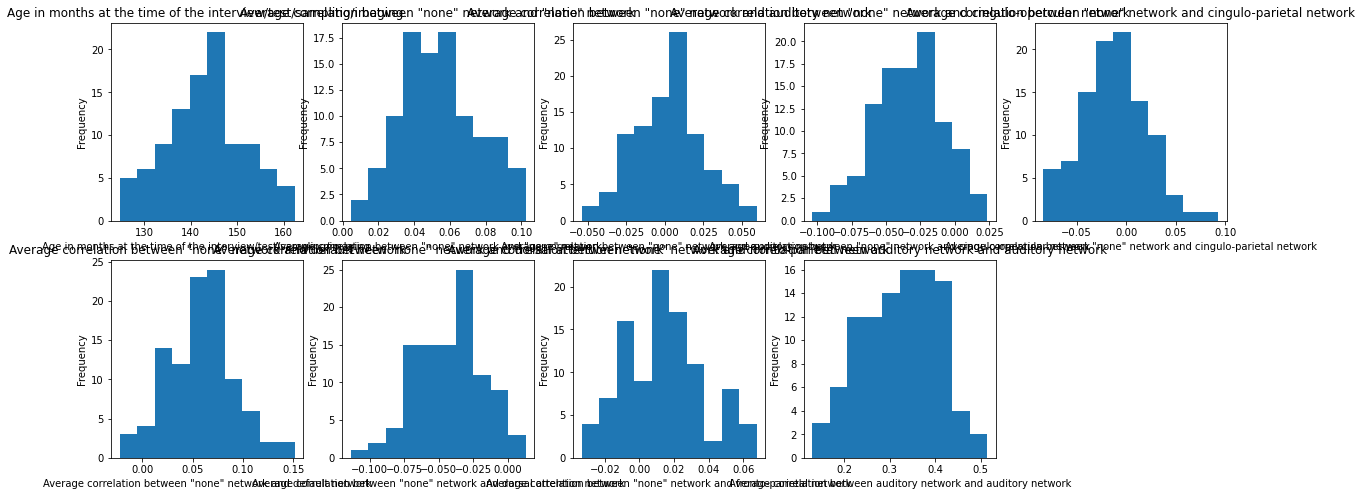

In [8]:
# Plot histograms of first 10 variables (just 10 for space reasons)

plt.figure(figsize=(20, 8)) 

for i in list(X.columns)[0:9]:
    plt.subplot(2, 5, list(X.columns).index(i)+1)
    plt.hist(X[i])
    plt.xlabel(i)
    plt.ylabel("Frequency")
    plt.title(i, wrap=True)   
    #plt.tight_layout()
    
# need to wrap titles

### Regress out confounding variables

In [9]:
# If we follow Ho et al., the first step is to regress out the effects of site, scanner type, 
# MRI serial number, mean framewise displacement, and number of outlier volumes (after dummy 
# coding each of these categorical variables) using ordinary least squares linear regression.

# Second step:
# "For all continuous features, missing values were imputed using the median value of the 
# respective feature; for all categorical features, missing values were imputed using the 
# modal value of the respective feature. Critically, data were imputed after splitting the
# data to prevent the risk of leakage between the training/validation and test sets."


## CODE NEEDS TO BE WRITTEN

### Model 1: Simple logistic regression with all features

In [10]:
# Initialize and fit logistic regression
log_reg = LogisticRegression().fit(X_train, y_train)

# Coefficients and intercept
log_reg_coefs = log_reg.coef_[0]
log_reg_intercept = log_reg.intercept_

# Accuracy
accuracy_log_reg_train = log_reg.score(X_train, y_train)
accuracy_log_reg_test = log_reg.score(X_test, y_test)

print(
    "\nThe classification accuracies for the logistic regression model are:"
    "\n\n\tTrain\t{:.4f}\n\tTest\t{:.4f}"
    .format(accuracy_log_reg_train, accuracy_log_reg_test)
)



The classification accuracies for the logistic regression model are:

	Train	0.8625
	Test	0.5000


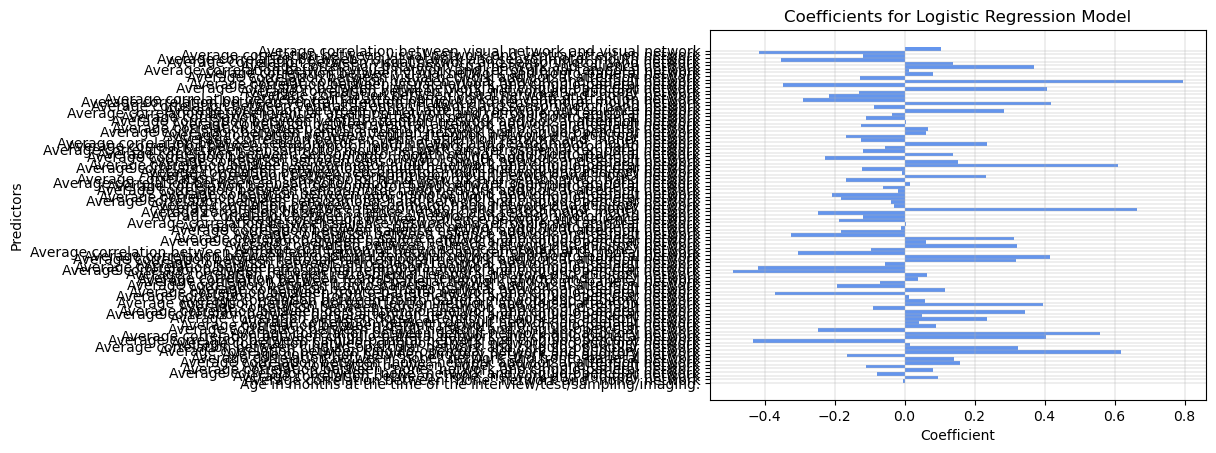

In [11]:
## Extract and plot coefficients

# Create a dictionary of the coefficients with the predictors as keys
log_reg_coef_dict = dict(zip(X_train.columns, np.transpose(log_reg.coef_[0])))

# Linear regression coefficients
log_reg_x = list(log_reg_coef_dict.keys())
log_reg_y = list(log_reg_coef_dict.values())

# Print the coefficients
# print("The regression coefficients are:", log_reg.coef_)

# Plot the coefficients
plt.rcdefaults()
plt.barh(log_reg_x, log_reg_y, 1.0, align='edge', color="cornflowerblue")
plt.grid(linewidth = 0.3)
plt.xlabel("Coefficient")
plt.ylabel("Predictors")
plt.title('Coefficients for Logistic Regression Model')
plt.show()

# NOTE: plot formatting is ridiculous because of very long variable names, but this won't 
# be the case with real data and plot formatting

### Model 2: Logistic regression with interaction terms + regularization

In [ ]:
# Create 2-way interactions between all variables
combinations = list(
    itertools.combinations(list(X_train.columns), 2)
)

interaction_colnames = []

for a, b in combinations:
    colname = '{} {}'.format(a, b)
    X_train[colname] = X_train[a] * X_train[b]
    X_test[colname] = X_test[a] * X_test[b]
    interaction_colnames.append(colname)

In [13]:
# Conduct logistic regression with interactions + regularization

logit_lasso_interact_predictors = list(X_train.columns) + interaction_colnames

Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
max_iter = 1000
penalty = "l1"
solver = "liblinear"

logit_lasso_interact = LogisticRegressionCV(
    Cs=Cs, cv=10, penalty=penalty, max_iter=max_iter, solver=solver).fit(X_train, y_train)

logit_lasso_interact_coefs = logit_lasso_interact.coef_[0]
logit_lasso_interact_intercept = logit_lasso_interact.intercept_

accuracy_train_logit_lasso_interact = logit_lasso_interact.score(X_train, y_train)
accuracy_test_logit_lasso_interact = logit_lasso_interact.score(X_test, y_test)

print(
    "\nThe classification accuracies for the logistic regression with interactions + regularization are:"
    "\n\n\tTrain\t{:.4f}\n\tTest\t{:.4f}"
    .format(accuracy_train_logit_lasso_interact, accuracy_test_logit_lasso_interact)
)



The classification accuracies for the logistic regression with interactions + regularization are:

	Train	1.0000
	Test	0.6500


In [14]:
# Which predictors are "important" (i.e., non-zero coefficient after regularization)?

number_coefs = len(logit_lasso_interact_coefs)
number_important_coefs = sum(logit_lasso_interact_coefs != 0)
number_unimportant_coefs = number_coefs - number_important_coefs 

print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        number_coefs, number_important_coefs, number_unimportant_coefs
    )
)

Of the 4278 predictors used in our 'logit_lasso_interact' model:

	91 predictors were deemed 'important' by our model
	4187 predictors were deemed 'unimportant' with 0-valued coefficients


In [15]:
# List important predictors
#bool_important_coefs = (logit_lasso_interact_coefs != 0)
#predictors_important = list(
#    np.array(X_train.columns)[bool_important_coefs]
#)
#
#print(
#    "The following predictors were deemed important by "
#    "the lasso regression model with interactions (i.e. coef != 0):\n\n\t{}\n\n\n"
#    "While, the remaining were deemed unimportant (i.e. "
#    "coef == 0):\n\n\t{}"
#    .format(
#        predictors_important,
#        np.array(X_train.columns)[~bool_important_coefs],
#    )
#)

# This output is too long, but if we only have a handful of important predictors it could be useful


### Model 3: Multilabel Logistic Regression

In [40]:
# Multilabel logistic regression

# simulate two time points of internalizing 0/1 data
y2_train = make_multilabel_classification(n_samples = 80, n_classes = 2, random_state = 0)
y2_test = make_multilabel_classification(n_samples = 20, n_classes = 2, random_state = 0)

# Fit the model on the training set
log_reg_multi = MultiOutputClassifier(LogisticRegression()).fit(X_train, y2_train[1])

# Accuracy
accuracy_train_log_multi = log_reg_multi.score(X_train, y2_train[1])
accuracy_test_log_multi = log_reg_multi.score(X_test, y2_test[1])

# Predictions
y_pred_train_log_multi = log_reg_multi.predict(X_train)
y_pred_test_log_multi = log_reg_multi.predict(X_test)

print(
    "\nThe classification accuracies for the multilabel logistic regression model are:"
    "\n\n\tTrain\t{:.4f}\n\tTest\t{:.4f}"
    .format(accuracy_train_log_multi, accuracy_test_log_multi)
)


/Users/katherinegrisanzio/opt/anaconda3/envs/env_name/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katherinegrisanzio/opt/anaconda3/envs/env_name/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s


The classification accuracies for the multilabel logistic regression model are:

	Train	1.0000
	Test	0.2500


### Model 4: Random forests

In [16]:
# Define a Random Forest regressor
random_forest = RandomForestClassifier(max_depth = 20, # maximum depth of the tree 
                                      n_estimators = 100, # number of trees in the forest
                                      max_features = "sqrt", # number of features to consider when looking for the best split (square root of total # of features)
                                      random_state = 109)

# Fit the model on the training set
random_forest.fit(X_train, y_train)

# Accuracy
accuracy_train_rf = random_forest.score(X_train, y_train)
accuracy_test_rf = random_forest.score(X_test, y_test)

# Predictions
rf_y_pred_train = random_forest.predict(X_train)
rf_y_pred_test = random_forest.predict(X_test)

print(
    "\nThe classification accuracies for the random forest model are:"
    "\n\n\tTrain\t{:.4f}\n\tTest\t{:.4f}"
    .format(accuracy_train_rf, accuracy_test_rf)
)



The classification accuracies for the random forest model are:

	Train	1.0000
	Test	0.4500


In [17]:
# Extract top predictors from fitted random forest trees

top_predictors_rf = [
    X_train.columns[model.tree_.feature[0]] # decision tree's top feature is stored as .tree_.feature[0]
    for model in random_forest.estimators_  # random forest object stores its decision trees in .estimators_ attribute
]

# Convert results to a pandas series
top_predictors_rf_df = pd.DataFrame(
    pd.Series(top_predictors_rf).value_counts(),
    columns=["Count"],
)

# Display results
print(f'Random forest "top predictor" frequencies (i.e., how many times it is used as the root node) for '
    f"each of the 100 ensemble trees:")
display(top_predictors_rf_df)

Random forest "top predictor" frequencies (i.e., how many times it is used as the root node) for each of the 100 ensemble trees:


,Count
Average correlation between ventral attention network and sensorimotor hand network Average correlation between visual network and sensorimotor hand network,2
Average correlation between sensorimotor mouth network and cingulo-opercular network Average correlation between visual network and ventral attention network,2
"Average correlation between salience network and ""none"" network Average correlation between visual network and ""none"" network",2
"Average correlation between ""none"" network and ""none"" network Average correlation between visual network and ""none"" network",2
"Average correlation between dorsal attention network and dorsal attention network Average correlation between visual network and ""none"" network",1
...,...
Average correlation between ventral attention network and cingulo-parietal network Average correlation between ventral attention network and sensorimotor hand network,1
"Average correlation between ventral attention network and sensorimotor mouth network Average correlation between visual network and ""none"" network",1
Average correlation between default network and cingulo-opercular network Average correlation between sensorimotor hand network and cingulo-opercular network,1
Age in months at the time of the interview/test/sampling/imaging. Average correlation between fronto-parietal network and default network,1


### Model 5: Multilabel Random Forests

In [19]:
# Multilabel random forests

# Fit the model on the training set
rf_reg_multi = MultiOutputClassifier(RandomForestClassifier()).fit(X_train, y2_train[1])

# Accuracy
accuracy_train_rf_multi = rf_reg_multi.score(X_train, y2_train[1])
accuracy_test_rf_multi = rf_reg_multi.score(X_test, y2_test[1])

# Predictions
y_pred_train_rf_multi = rf_reg_multi.predict(X_train)
y_pred_test_rf_multi = rf_reg_multi.predict(X_test)

print(
    "\nThe classification accuracies for the multilabel random forest model are:"
    "\n\n\tTrain\t{:.4f}\n\tTest\t{:.4f}"
    .format(accuracy_train_rf_multi, accuracy_test_rf_multi)
)


The classification accuracies for the multilabel random forest model are:

	Train	1.0000
	Test	0.4500


### Model 6: Gradient boosting classifier

Boosting is a method of converting weak learners into strong learners, i.e., by building prediction models sequentially where each model tries to predict the error left over by the previous model. In Gradient Boosting, we begin by training a decision tree in which each observation is assigned an equal weight. After evaluating our model, a higher weight is put on observations that the model failed to predict accurately. The next tree is then weighted on this data. Then, the third tree is trained to predict the new residuals. This process is repeated for a given number of iterations. The final prediction is a weighted sum of the predictions made by all the trees. A unique feature of Gradient Boosting is that it uses gradients to allow optimization of a differentiable loss function, which measures how well the model’s coefficients are fitting the underlying data.  

In [20]:
gbr = GradientBoostingClassifier(n_estimators = 800, 
                                max_depth = 5, 
                                learning_rate = 0.08)
gbr.fit(X_train, y_train)

# Accuracy
gbr_acc = gbr.score(X_train, y_train)
gbr_acc = gbr.score(X_test, y_test)

# Predictions
gbr_y_pred_train = gbr.predict(X_train)
gbr_y_pred_test = gbr.predict(X_test)


In [21]:
# Sorted feature importance
imp_features_gbr = pd.DataFrame({'col_name': gbr.feature_importances_}, index=X_train.columns).sort_values(by='col_name', ascending=False)
imp_features_gbr.head()


,col_name
Average correlation between ventral attention network and sensorimotor hand network Average correlation between visual network and sensorimotor hand network,0.240150
"Average correlation between ""none"" network and default network Average correlation between sensorimotor hand network and cingulo-parietal network",0.195390
Average correlation between auditory network and auditory network Average correlation between salience network and cingulo-opercular network,0.183865
Average correlation between dorsal attention network and default network Average correlation between ventral attention network and cingulo-parietal network,0.062610
Average correlation between dorsal attention network and cingulo-parietal network Average correlation between fronto-parietal network and default network,0.048617


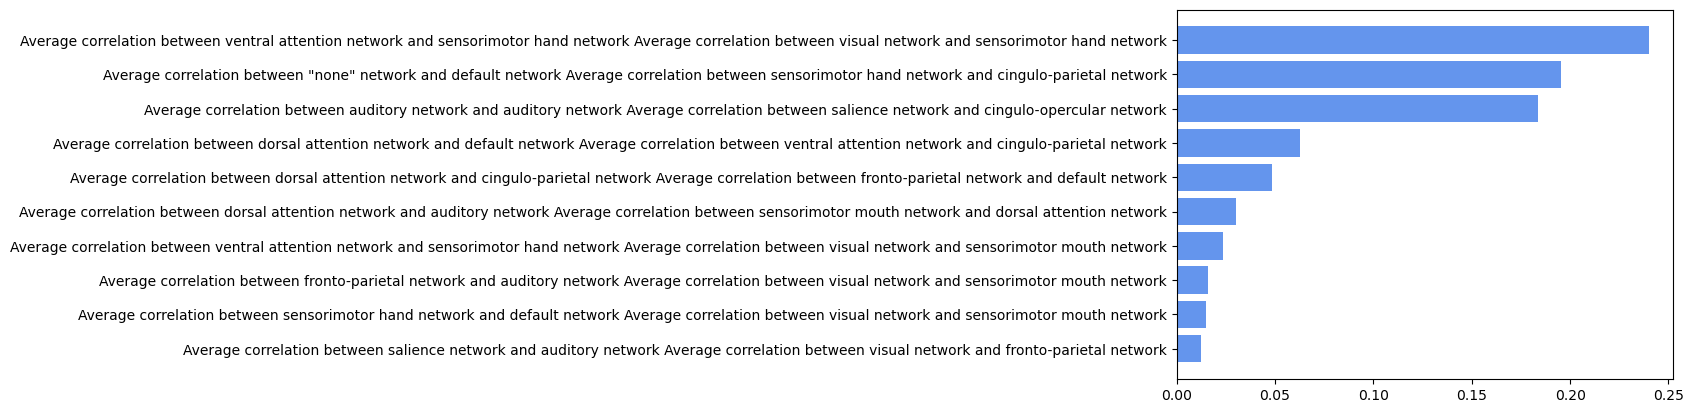

In [22]:
# Plot feature importances
imp_features_gbr_sorted = imp_features_gbr[:10].iloc[::-1]
plt.barh(list(imp_features_gbr_sorted.index), imp_features_gbr_sorted.col_name.values, color = 'cornflowerblue')
plt.show()

### Model 7: Multilabel Gradient Boosting Classifier 

In [38]:
# Fit the model on the training set
gbr_multi = MultiOutputClassifier(GradientBoostingClassifier()).fit(X_train, y2_train[1])

# Accuracy
accuracy_train_gbr_multi = gbr_multi.score(X_train, y2_train[1])
accuracy_test_gbr_multi = gbr_multi.score(X_test, y2_test[1])

# Predictions
y_pred_train_gbr_multi = gbr_multi.predict(X_train)
y_pred_test_gbr_multi = gbr_multi.predict(X_test)

print(
    "\nThe classification accuracies for the multilabel gradient boosting classifier are:"
    "\n\n\tTrain\t{:.4f}\n\tTest\t{:.4f}"
    .format(accuracy_train_gbr_multi, accuracy_test_gbr_multi)
)


The classification accuracies for the multilabel gradient boosting classifier are:

	Train	1.0000
	Test	0.3500


### Model 8: Neural network

In [23]:
nodes = 15

NN_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(nodes, activation="relu"),
        tf.keras.layers.Dense(nodes, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                64185     
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 64,441
Trainable params: 64,441
Non-trainable params: 0
_________________________________________________________________


2022-08-04 18:26:07.960946: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
# Set parameters
loss_fn = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam()
batch_size = 128
epochs = 15
validation_split = 0.2
verbose = 0

# Compile model
NN_model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)

# Fit model
history_NN = NN_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_split=validation_split,
    epochs=epochs,
    verbose=verbose,
)

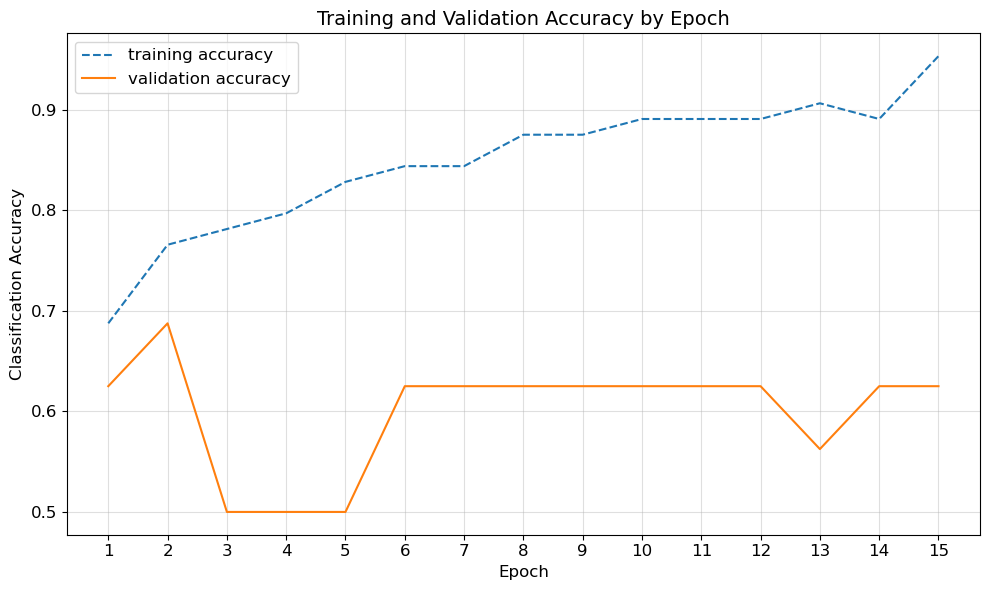

In [30]:
# Plot train and val accuracy as a function of epochs

fig, ax = plt.subplots(figsize=(10, 6))

x_axis_vals = np.array(range(len(history_NN.history["accuracy"])))+1

plt.title("Training and Validation Accuracy by Epoch".format(
        len(x_axis_vals)), fontsize=14,)

plt.plot(x_axis_vals, history_NN.history["accuracy"], "--", label="training accuracy",)

plt.plot(x_axis_vals, history_NN.history["val_accuracy"], "-", label="validation accuracy",)

ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Classification Accuracy", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
        
plt.tight_layout()
plt.show();


In [31]:
# Accuracy
nn_acc_train = NN_model.evaluate(X_train, y_train)[1]
nn_acc_test = NN_model.evaluate(X_test, y_test)[1]

print(
    "\nThe resulting accuracy scores for the neural network are:\n\n"
    "\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(nn_acc_train, nn_acc_test)
)

1/1 [==============================] - 0s 16ms/step - loss: 0.9617 - accuracy: 0.6500

The resulting accuracy scores for the neural network are:

	Train	0.8875
	TEST	0.6500


### Model 9: Multilabel feed-forward neural network

In [45]:
# Build model
NN_model_multilabel = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(nodes, activation="relu"),
        tf.keras.layers.Dense(nodes, activation="relu"),
        tf.keras.layers.Dense(2, activation="sigmoid"),
    ]
)

# Compile model
NN_model_multilabel.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)

# Fit model
history_multilabel = NN_model_multilabel.fit(
    X_train, y2_train[1],
    batch_size=batch_size,
    validation_split=validation_split,
    epochs=epochs,
    verbose=verbose,
)

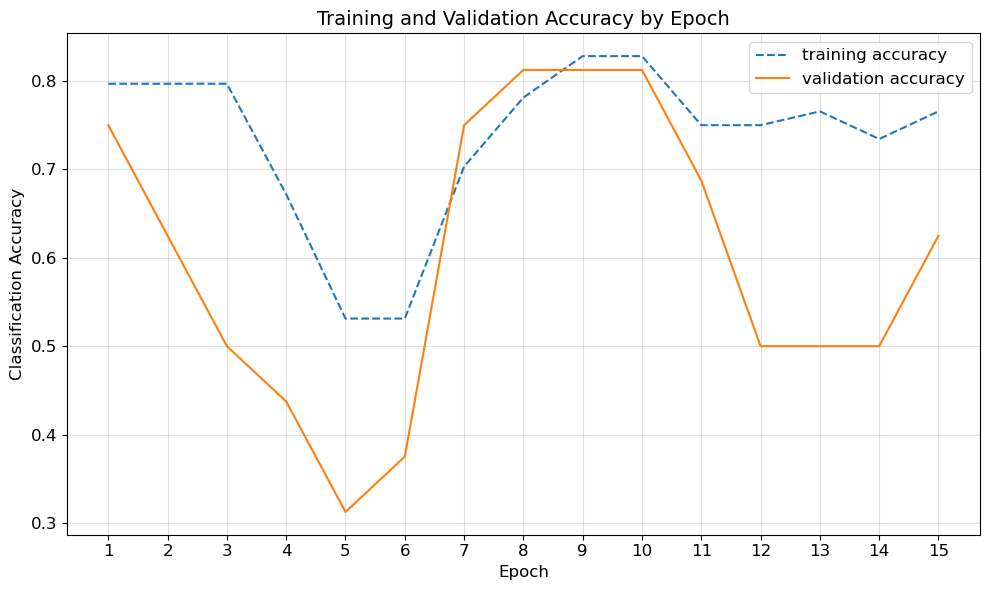

In [47]:
# Plot train and val accuracy as a function of epochs

fig, ax = plt.subplots(figsize=(10, 6))

x_axis_vals = np.array(range(len(history_multilabel.history["accuracy"])))+1

plt.title("Training and Validation Accuracy by Epoch".format(
        len(x_axis_vals)), fontsize=14,)

plt.plot(x_axis_vals, history_multilabel.history["accuracy"], "--", label="training accuracy",)

plt.plot(x_axis_vals, history_multilabel.history["val_accuracy"], "-", label="validation accuracy",)

ax.tick_params(labelsize=12)
ax.set_xticks(x_axis_vals)
ax.set_ylabel("Classification Accuracy", fontsize=12)
ax.set_xlabel("Epoch", fontsize=12)
ax.grid(':', alpha=0.4)
ax.legend(fontsize=12)
        
plt.tight_layout()
plt.show();

In [48]:
# Accuracy
nn_multi_acc_train = NN_model_multilabel.evaluate(X_train, y2_train[1])[1]
nn_multi_acc_test = NN_model_multilabel.evaluate(X_test, y2_test[1])[1]

print(
    "\nThe resulting accuracy scores for the neural network are:\n\n"
    "\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(nn_multi_acc_train, nn_multi_acc_test)
)

1/1 [==============================] - 0s 23ms/step - loss: 0.5938 - accuracy: 0.6500

The resulting accuracy scores for the neural network are:

	Train	0.7750
	TEST	0.6500


### Model evaluation

In [51]:
# Create dictionary of models and their corresponding accuracy values
d = {'Model': ["Logistic Regression", "Logistic Regression + Interactions + Regularization", 
               "Multilabel Logistic Regression", "Random Forest Classifier", "Multilabel Random Forest", 
               "Gradient Boosting Classifier", "Multilabel Gradient Boosting", "Neural Network", "Multilabel Neural Network"], 
     'Test Accuracy': [accuracy_log_reg_test, accuracy_test_logit_lasso_interact, accuracy_test_log_multi, 
                       accuracy_test_rf, accuracy_test_rf_multi, gbr_acc, accuracy_test_gbr_multi, nn_acc_test, 
                       nn_multi_acc_test]}

# Create dataframe from dictionary
results_df = pd.DataFrame(data=d)
results_df


,Model,Test Accuracy
0,Logistic Regression,0.50
1,Logistic Regression + Interactions + Regulariz...,0.65
2,Multilabel Logistic Regression,0.25
3,Random Forest Classifier,0.45
4,Multilabel Random Forest,0.45
5,Gradient Boosting Classifier,0.60
6,Multilabel Gradient Boosting,0.35
7,Neural Network,0.65
8,Multilabel Neural Network,0.65
